
 Tuning LR...
✅ LR Accuracy: 0.9737
Best Parameters: {'clf__C': 1}

 Tuning RF...
✅ RF Accuracy: 0.9649
Best Parameters: {'clf__max_depth': 5, 'clf__n_estimators': 100}

 Tuning XGB...
✅ XGB Accuracy: 0.9561
Best Parameters: {'clf__learning_rate': 0.3, 'clf__n_estimators': 100}

 Tuning SVC...
✅ SVC Accuracy: 0.9825
Best Parameters: {'clf__C': 0.1, 'clf__kernel': 'linear'}

Voting Ensemble Accuracy: 0.9737
Voting Ensemble Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96        43
           1       0.96      1.00      0.98        71

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Stacking Ensemble Accuracy: 0.9649
Stacking Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        43
           1       0.97      0.97  

C:\Users\Koushik SM\AppData\Local\Temp\ipykernel_18600\1961514514.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.values()), y=list(accuracies.keys()), palette='viridis')


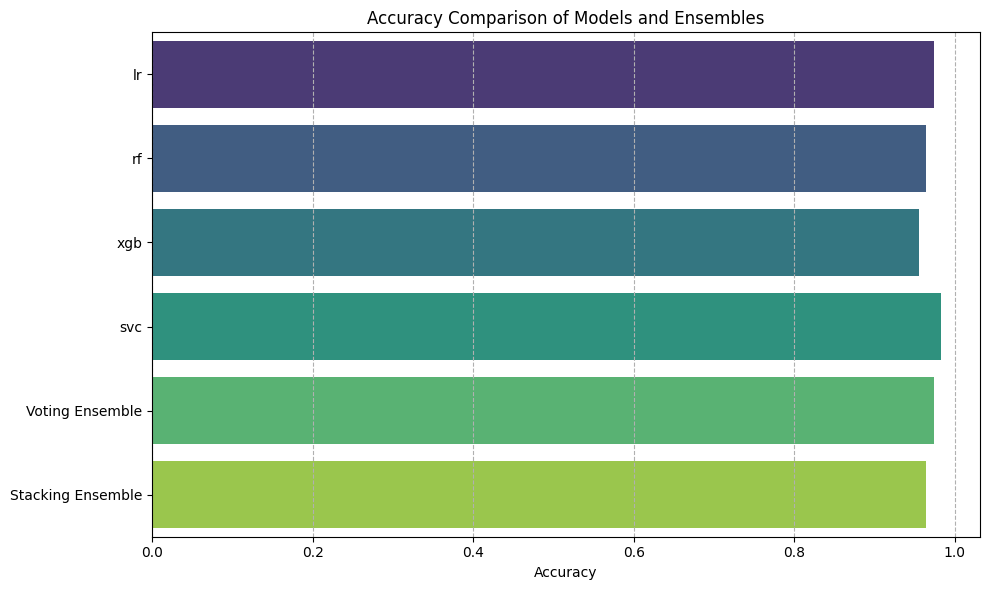

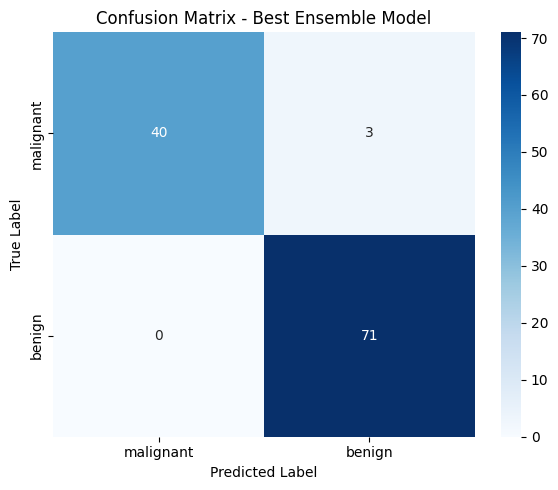

In [1]:
# Uncomment to install dependencies if needed
# !pip install scikit-learn xgboost matplotlib seaborn

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import pickle

# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Define hyperparameter grids
param_grids = {
    'lr': {'clf__C': [0.1, 1, 10]},
    'rf': {'clf__n_estimators': [50, 100],
           'clf__max_depth': [3, 5, None]},
    'xgb': {'clf__n_estimators': [50, 100],
            'clf__learning_rate': [0.01, 0.1, 0.3]},
    'svc': {'clf__C': [0.1, 1],
            'clf__kernel': ['linear', 'rbf']}
}

# Create pipelines with consistent naming
pipelines = {
    'lr': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(random_state=42))]),
    'rf': Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(random_state=42))]),
    'xgb': Pipeline([('scaler', StandardScaler()), ('clf', XGBClassifier(use_label_encoder=False,
                                                                         eval_metric='logloss',
                                                                         random_state=42))]),
    'svc': Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True, random_state=42))])
}

best_models = {}
accuracies = {}

# Hyperparameter tuning
for name, pipe in pipelines.items():
    print(f"\n Tuning {name.upper()}...")
    grid = GridSearchCV(pipe, param_grids[name], cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    preds = grid.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies[name] = acc
    print(f"✅ {name.upper()} Accuracy: {acc:.4f}")
    print("Best Parameters:", grid.best_params_)

# Build Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_models['lr']),
        ('rf', best_models['rf']),
        ('xgb', best_models['xgb']),
        ('svc', best_models['svc']),
        ('gnb', GaussianNB())
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
voting_acc = accuracy_score(y_test, voting_pred)
accuracies['Voting Ensemble'] = voting_acc

print(f"\nVoting Ensemble Accuracy: {voting_acc:.4f}")
print("Voting Ensemble Classification Report:\n", classification_report(y_test, voting_pred))

# Build Stacking Classifier
stack_clf = StackingClassifier(
    estimators=[
        ('lr', best_models['lr']),
        ('rf', best_models['rf']),
        ('xgb', best_models['xgb'])
    ],
    final_estimator=GaussianNB()
)
stack_clf.fit(X_train, y_train)
stack_pred = stack_clf.predict(X_test)
stack_acc = accuracy_score(y_test, stack_pred)
accuracies['Stacking Ensemble'] = stack_acc

print(f"\nStacking Ensemble Accuracy: {stack_acc:.4f}")
print("Stacking Ensemble Classification Report:\n", classification_report(y_test, stack_pred))

# Save the best ensemble model
final_best_model = stack_clf if stack_acc > voting_acc else voting_clf
model_name = 'best_ensemble_model.pkl'
with open(model_name, 'wb') as f:
    pickle.dump(final_best_model, f)

print(f"\nSaved best model: {'Stacking' if stack_acc > voting_acc else 'Voting'} to '{model_name}'")

# Visualize Accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.values()), y=list(accuracies.keys()), palette='viridis')
plt.xlabel("Accuracy")
plt.title("Accuracy Comparison of Models and Ensembles")
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

# Confusion Matrix for Best Model
best_preds = final_best_model.predict(X_test)
cm = confusion_matrix(y_test, best_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.title("Confusion Matrix - Best Ensemble Model")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [2]:
import json
import pickle

# Assume you already have this dict of accuracies
accuracies = {
    'Logistic Regression': accuracies['lr'],  # from your grid search results
    'Random Forest': accuracies['rf'],
    'XGBoost': accuracies['xgb'],
    'SVC': accuracies['svc'],
    'Voting Ensemble': accuracies['Voting Ensemble'],
    'Stacking Ensemble': accuracies['Stacking Ensemble']
}

# Save accuracies dict to JSON file
with open('accuracies.json', 'w') as f:
    json.dump(accuracies, f)


